In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!tar xfz images.tar.gz
!rm images.tar.gz

--2024-04-20 09:07:29--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2024-04-20 09:07:29--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  76.4MB/s    in 24s     

2024-04-20 09:07:53 (31.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [4]:
import time
import tqdm
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision as tv
from torchvision import datasets, models, transforms
import torch.optim as optim
from IPython.display import clear_output
import glob
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
import seaborn as sns


%matplotlib inline

In [ ]:
def display_images(l,titles=None,fontsize=10):
    n=len(l)
    fig,ax = plt.subplots(1, 2)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*10)
    plt.tight_layout()
    plt.show()

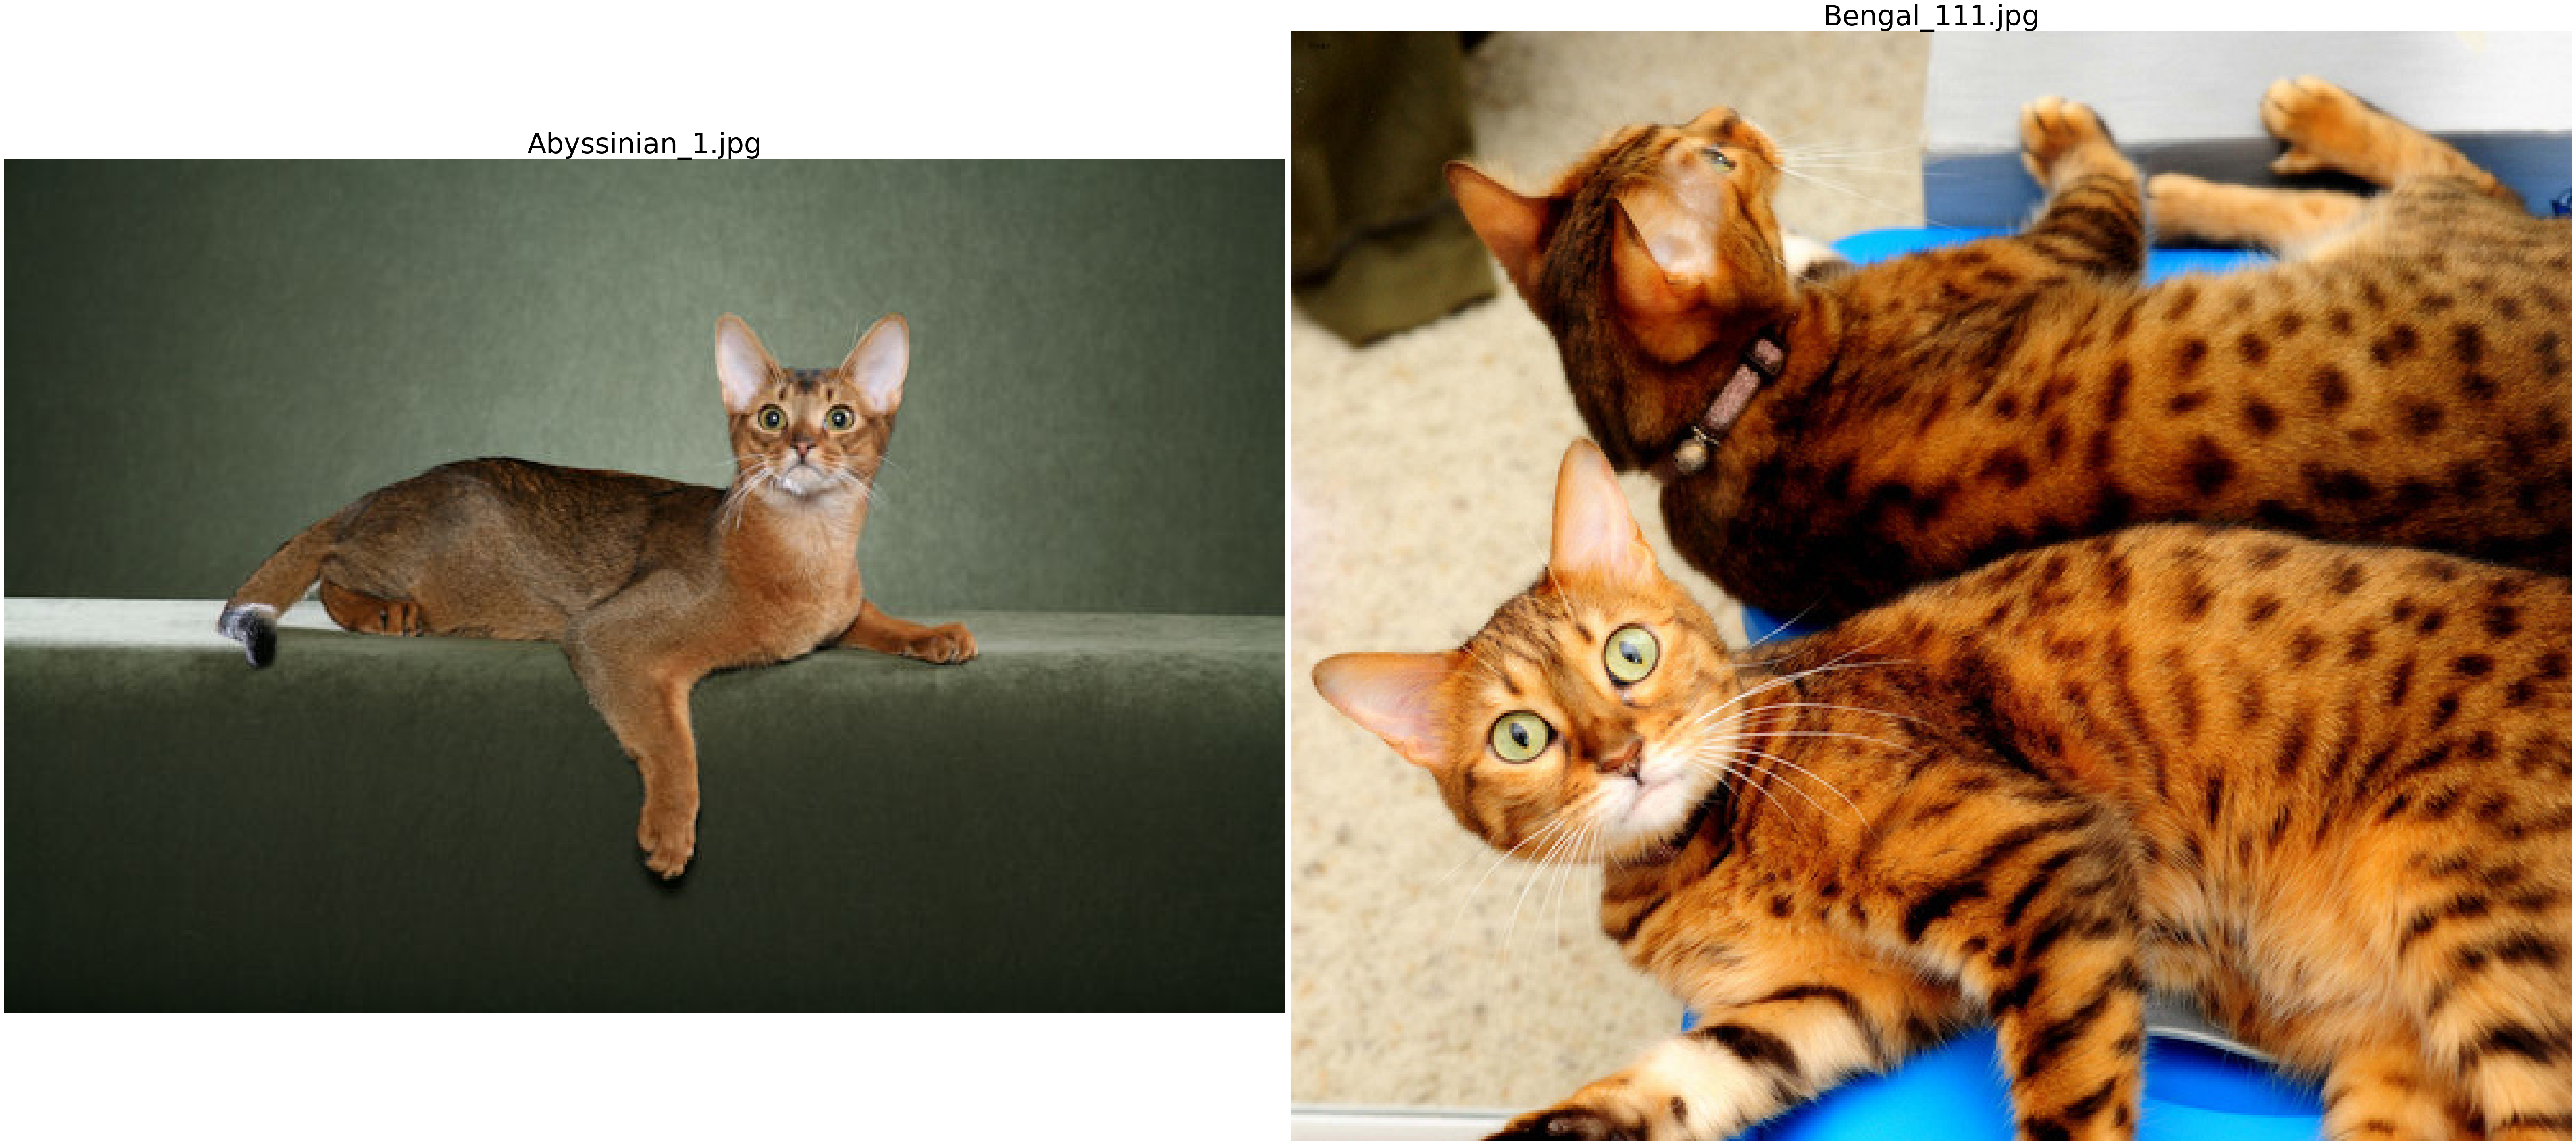

In [ ]:
# Загрузка изображений
image1 = Image.open("images/Abyssinian_1.jpg", "r")
image2 = Image.open("images/Bengal_111.jpg", "r")

# Отображение изображений
display_images([image1, image2], titles=['Abyssinian_1.jpg', 'Bengal_111.jpg'], fontsize=50)

In [ ]:
import os
import shutil

# Путь к папке, в которой находятся все файлы
folder_path = "images/"

# Получаем список всех файлов в указанной папке
files = os.listdir(folder_path)

# Создаем словарь для хранения пород и соответствующих папок
breeds = {}

# Проходимся по всем файлам и добавляем их в соответствующую папку
for file in files:
    breed = file.split('_')[0]
    if breed in breeds:
        shutil.move(os.path.join(folder_path, file), os.path.join(folder_path, breed, file))
    else:
        os.makedirs(os.path.join(folder_path, breed), exist_ok=True)
        shutil.move(os.path.join(folder_path, file), os.path.join(folder_path, breed, file))
        breeds[breed] = True

In [ ]:
# разделим картинки на train и test в отношении 80 на 20 для каждого класса
data_dir = "images/"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, test_files_path = train_test_split(
    data_image_paths,
    test_size=0.2,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в test: {len(test_files_path)}"
)


Изображений в train: 5912
Изображений в test: 1478


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

test_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=test_transform,
    is_valid_file=lambda x: x in test_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в test: ", len(test_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(test_dataset.classes))

Количество классов в train:  35
Количество классов в test:  35
Количество классов одинаково:  True


In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
# Вывод изображений и их меток на печать для предварительного просмотра
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=3, ncols=3, figsize=(8, 8),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=800)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

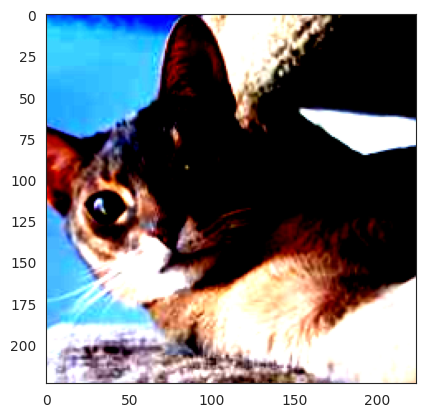

Abyssinian


In [ ]:
image,label = train_dataset[77]
plt.imshow(image.permute(1,2,0))
plt.show()
print(train_dataset.classes[label])

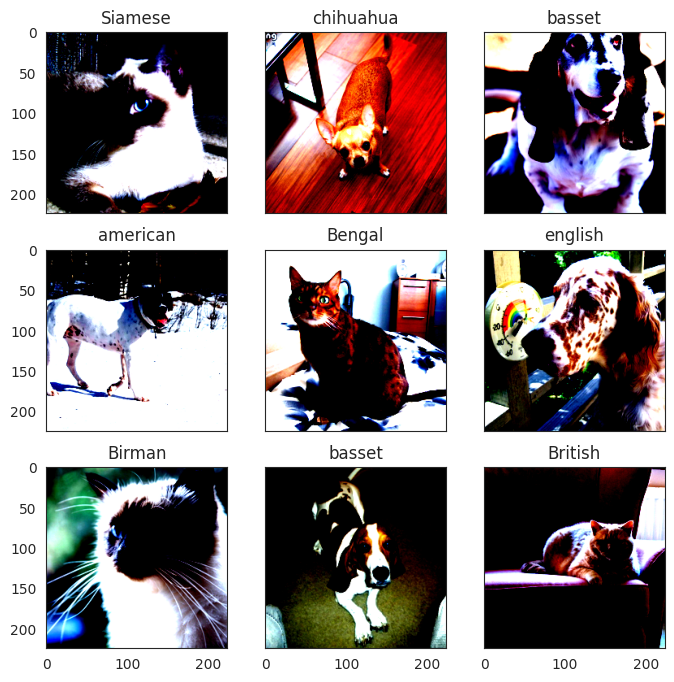

In [ ]:
show_images(test_dataset)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['test'], label='test')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['test'], label='test')
    plt.ylabel('acc', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    test_batch_gen,
    scheduler,
    num_epochs
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()



            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        scheduler.step()

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по тестовому датасету
        for X_batch, y_batch in test_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            test_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            test_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        test_loss /= len(test_batch_gen)
        test_acc /= len(test_batch_gen)
        history['loss']['test'].append(test_loss)
        history['acc']['test'].append(test_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  train loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  test loss (in-iteration): \t{:.6f}".format(test_loss))
        print("  train accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  test accuracy: \t\t\t{:.2f} %".format(test_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=True
)
# тестовый датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

### ResNet18

In [ ]:
from torchvision.models import resnet18

In [ ]:
model = resnet18(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 30 of 30 took 48.486s
  train loss (in-iteration): 	0.377031
  test loss (in-iteration): 	0.320604
  train accuracy: 			88.99 %
  test accuracy: 			90.52 %


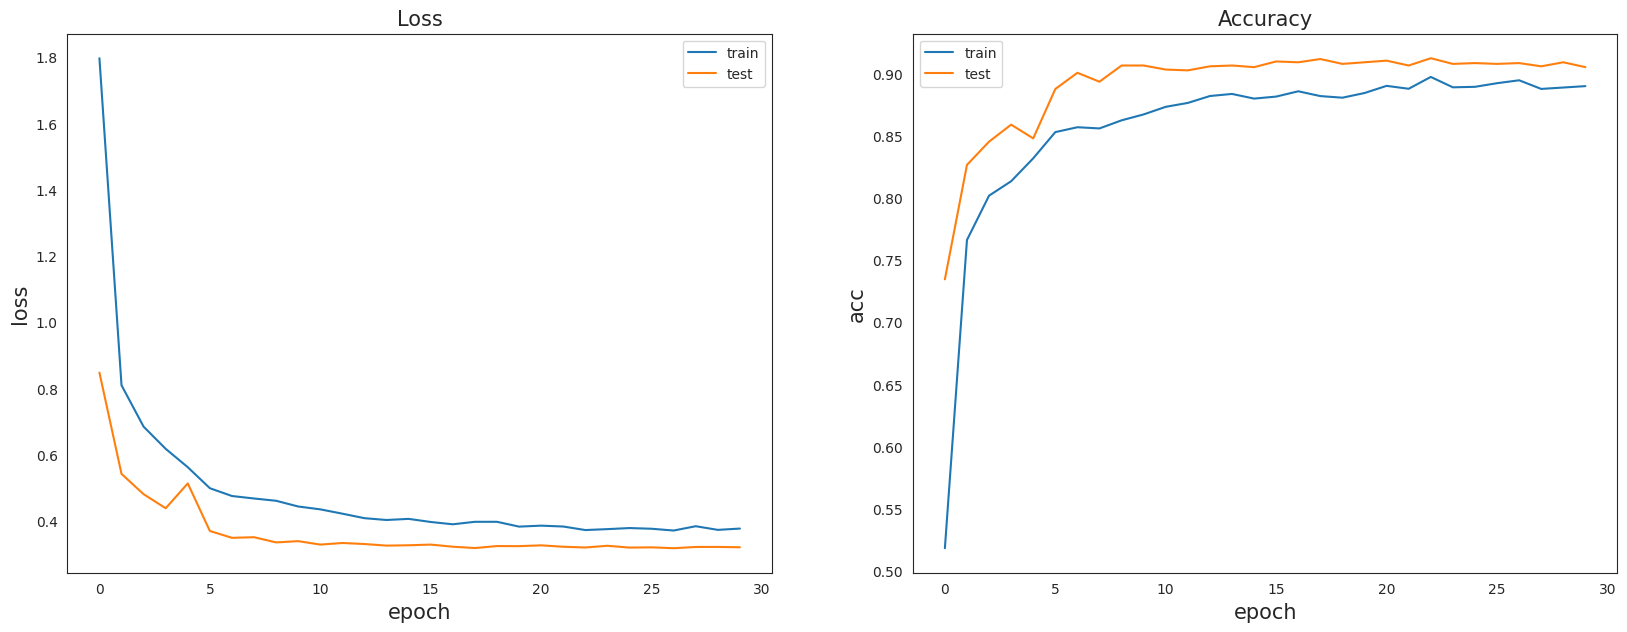

In [ ]:
# возьмём предобученную сеть
fe_model_sched = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model_sched.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model_sched.fc = nn.Linear(512, 35)
fe_model_sched = fe_model_sched.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model_sched.parameters(), lr=0.1)

# добавим scheduler StepLR для пошагового снижения скорости обучения
scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

clf_model, history = train(
    fe_model_sched, criterion, optimizer,
    train_batch_gen, test_batch_gen,
    scheduler,
    num_epochs=30
)


In [ ]:
# Сохранение модели
torch.save(model.state_dict(), 'model_resnet18.pth')

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
#idxs = list(range(len(test_dataset)))
idxs = list(map(int, np.random.uniform(0, len(test_dataset), 20)))
imgs = [test_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims_resnet18 = predict(fe_model_sched, imgs)
y_pred_resnet = np.argmax(probs_ims_resnet18,-1)
y_pred_resnet = list(y_pred_resnet)
print('ResNet18:     ', y_pred_resnet)
actual_labels = [test_dataset[id][1] for id in idxs]
print('Right answer: ', actual_labels)

ResNet18:      [6, 28, 30, 25, 12, 12, 13, 29, 4, 19, 31, 17, 10, 17, 17, 27, 24, 14, 24, 5]
Right answer:  [6, 28, 30, 25, 12, 12, 13, 8, 4, 19, 31, 17, 10, 17, 17, 27, 24, 14, 24, 5]


In [ ]:
from sklearn.metrics import f1_score
sc_resnet=f1_score(actual_labels, y_pred_resnet, average='macro')
print ('ResNet18: F1_score=', sc_resnet)

ResNet18: F1_score= 0.9078682662751373


In [ ]:
n_classes = len(np.unique(test_dataset.classes))
print("we will classify :{}".format(n_classes))

we will classify :35


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

def show_confusion_matrix_fucn(model):

    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()


    with torch.no_grad():
        for inputs, labels in test_batch_gen:
            predictions = model(inputs.to(device))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)


            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(test_batch_gen.dataset.classes))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()


    cm = confusion_matrix(y_test_all, predictions_all)#, np.arange(n_classes))

    plot_confusion_matrix(cm, feature_names, normalize=True)

    return y_test_all, predictions_all

def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(test_batch_gen.dataset.classes))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))



In [ ]:
BATCH_SIZE = 64

dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'test': torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'test':len(test_dataset)}

ResNet18:
Normalized confusion matrix
[41, 42, 36, 40, 36, 35, 35, 41, 46, 38, 44, 44, 91, 39, 42, 35, 36, 82, 36, 38, 40, 40, 42, 41, 41, 39, 40, 39, 38, 45, 41, 42, 36, 38, 39]
35
Accuracy of Abyssinian : 85 %
Accuracy of Bengal : 78 %
Accuracy of Birman : 83 %
Accuracy of Bombay : 97 %
Accuracy of British : 94 %
Accuracy of Egyptian : 91 %
Accuracy of Maine : 94 %
Accuracy of Persian : 85 %
Accuracy of Ragdoll : 71 %
Accuracy of Russian : 94 %
Accuracy of Siamese : 88 %
Accuracy of Sphynx : 90 %
Accuracy of american : 80 %
Accuracy of basset : 92 %
Accuracy of beagle : 83 %
Accuracy of boxer : 97 %
Accuracy of chihuahua : 88 %
Accuracy of english : 95 %
Accuracy of german : 100 %
Accuracy of great : 97 %
Accuracy of havanese : 90 %
Accuracy of japanese : 100 %
Accuracy of keeshond : 92 %
Accuracy of leonberger : 95 %
Accuracy of miniature : 85 %
Accuracy of newfoundland : 100 %
Accuracy of pomeranian : 100 %
Accuracy of   pug : 100 %
Accuracy of saint : 100 %
Accuracy of samoyed : 8

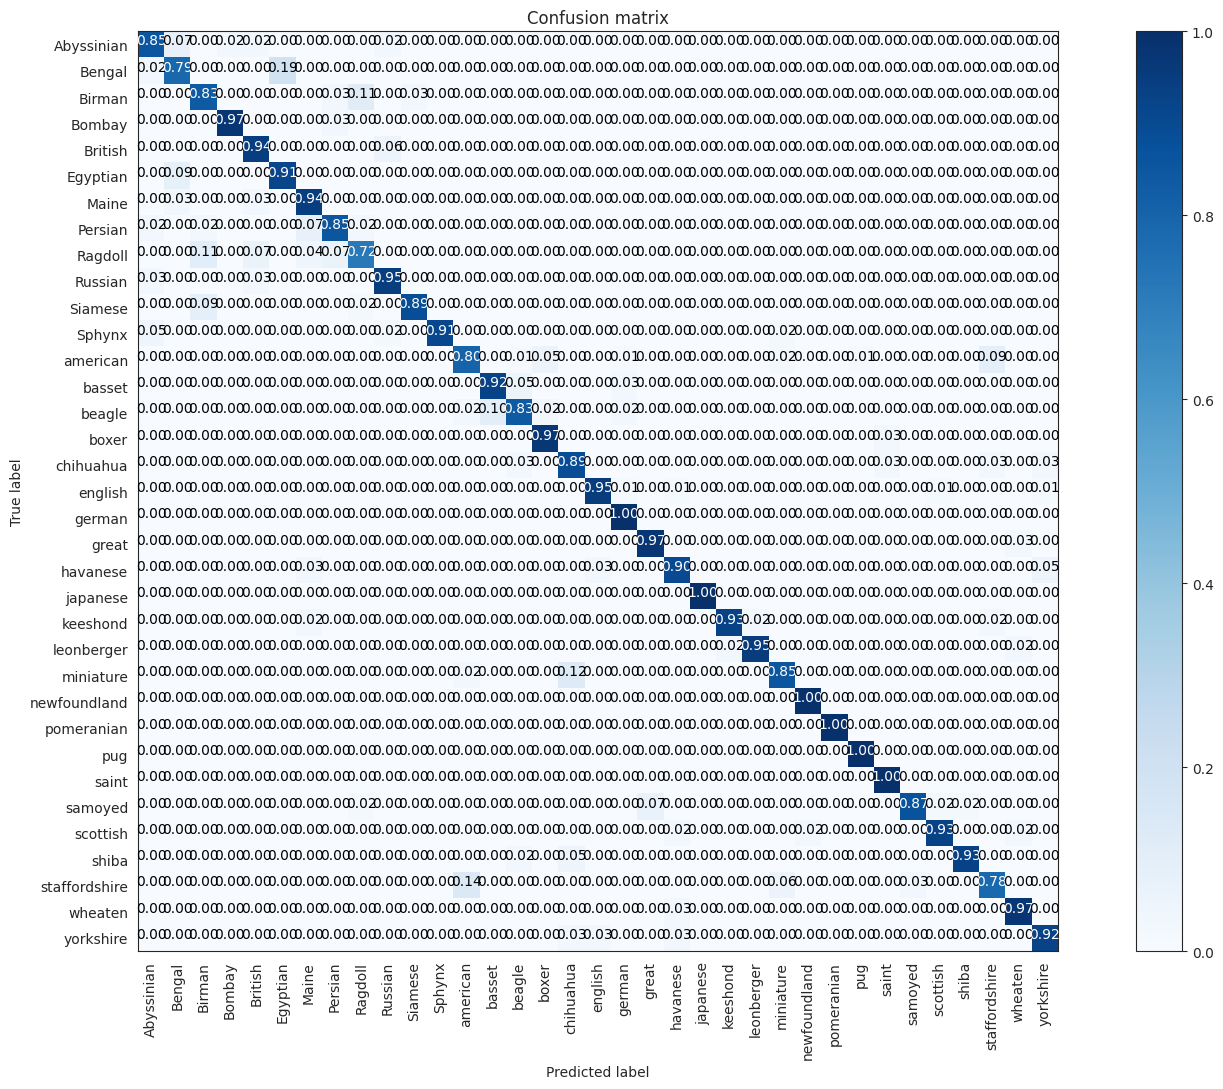

In [ ]:
print ('ResNet18:')
y_test_all, predictions_all = show_confusion_matrix_fucn(fe_model_sched)
accurancy_for_each_class(y_test_all, predictions_all)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `model` is your convolutional model
fe_model_sched = fe_model_sched.to(device)

In [ ]:
top3_correct = 0
top5_correct = 0

with torch.no_grad():
    for inputs, labels in test_batch_gen:
        predictions = fe_model_sched(inputs.to(device))
        _, top3_indices = torch.topk(predictions, k=3, dim=1)
        _, top5_indices = torch.topk(predictions, k=5, dim=1)

        for i in range(len(labels)):
            true_label = labels[i]

            if true_label.item() in top3_indices[i]:
                top3_correct += 1

            if true_label.item() in top5_indices[i]:
                top5_correct += 1

top3_accuracy = top3_correct * 100 / len(test_batch_gen.dataset)
top5_accuracy = top5_correct * 100 / len(test_batch_gen.dataset)

print('Top-3 Accuracy: {}%'.format(top3_accuracy))
print('Top-5 Accuracy: {}%'.format(top5_accuracy))

Top-3 Accuracy: 98.57916102841678%
Top-5 Accuracy: 99.45872801082544%


### VGG16

In [ ]:
from torchvision.models import vgg16

In [ ]:
model = vgg16(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 30 of 30 took 76.075s
  train loss (in-iteration): 	0.595867
  test loss (in-iteration): 	0.310379
  train accuracy: 			82.70 %
  test accuracy: 			91.34 %


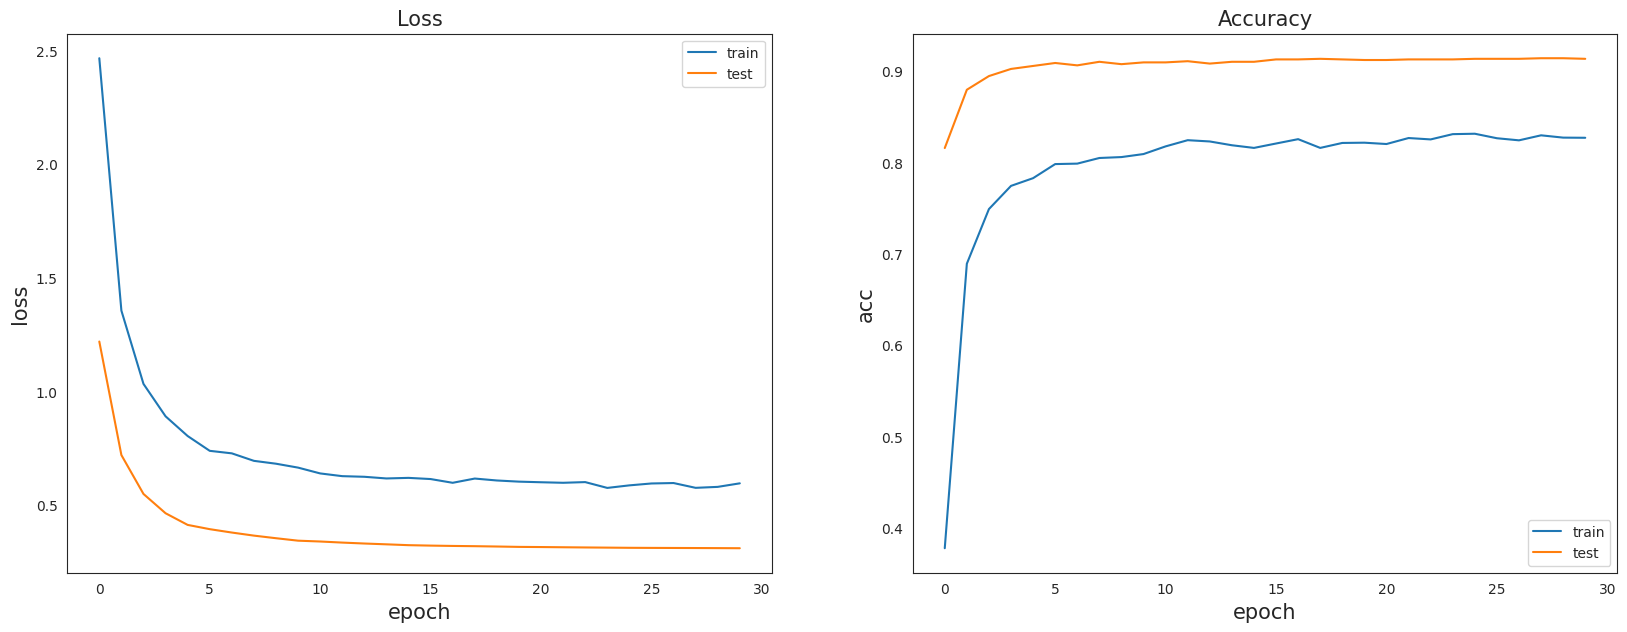

In [ ]:
# возьмём предобученную сеть
fe_model_sсhed_2 = vgg16(pretrained=True).to(device)

# заморозим все слои сети
for param in fe_model_sсhed_2.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model_sсhed_2.classifier
fe_model_sсhed_2.classifier[6] = nn.Linear(in_features=4096, out_features=35).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fe_model_sсhed_2.parameters(), lr=0.0001)

# добавим scheduler StepLR для пошагового снижения скорости обучения
scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

clf_model, history = train(
    fe_model_sсhed_2, criterion, optimizer,
    train_batch_gen, test_batch_gen,
    scheduler,
    num_epochs=30
)

In [ ]:
# Сохранение модели
torch.save(model.state_dict(), 'model_vgg16.pth')

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
#idxs = list(range(len(test_dataset)))
idxs = list(map(int, np.random.uniform(0, len(test_dataset), 20)))
imgs = [test_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims_vgg16 = predict(fe_model_sсhed_2, imgs)
y_pred_vgg = np.argmax(probs_ims_vgg16,-1)
y_pred_vgg = list(y_pred_vgg)
print('VGG16:        ', y_pred_vgg)
actual_labels = [test_dataset[id][1] for id in idxs]
print('Right answer: ', actual_labels)

VGG16:         [9, 11, 9, 12, 8, 29, 24, 5, 20, 24, 32, 18, 27, 31, 18, 0, 17, 34, 2, 28]
Right answer:  [9, 11, 9, 12, 8, 29, 24, 5, 20, 24, 32, 18, 27, 31, 18, 0, 17, 34, 2, 28]


In [ ]:
from sklearn.metrics import f1_score
sc_vgg=f1_score(actual_labels, y_pred_vgg, average='macro')
print ('VGG16: F1_score=', sc_vgg)

VGG16: F1_score= 0.9110423761420041


In [ ]:
n_classes = len(np.unique(test_dataset.classes))
print("we will classify :{}".format(n_classes))

we will classify :35


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

def show_confusion_matrix_fucn(model):

    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()


    with torch.no_grad():
        for inputs, labels in test_batch_gen:
            predictions = model(inputs.to(device))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)


            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(test_batch_gen.dataset.classes))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()


    cm = confusion_matrix(y_test_all, predictions_all)#, np.arange(n_classes))

    plot_confusion_matrix(cm, feature_names, normalize=True)

    return y_test_all, predictions_all

def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(test_batch_gen.dataset.classes))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
BATCH_SIZE = 64

dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'test': torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'test':len(test_dataset)}

VGG16:
Normalized confusion matrix
[35, 43, 47, 42, 38, 36, 38, 42, 42, 40, 36, 41, 84, 43, 39, 40, 36, 81, 39, 40, 42, 40, 40, 40, 44, 39, 41, 40, 39, 42, 41, 39, 32, 39, 38]
35
Accuracy of Abyssinian : 88 %
Accuracy of Bengal : 86 %
Accuracy of Birman : 70 %
Accuracy of Bombay : 95 %
Accuracy of British : 81 %
Accuracy of Egyptian : 94 %
Accuracy of Maine : 94 %
Accuracy of Persian : 88 %
Accuracy of Ragdoll : 76 %
Accuracy of Russian : 82 %
Accuracy of Siamese : 94 %
Accuracy of Sphynx : 92 %
Accuracy of american : 79 %
Accuracy of basset : 88 %
Accuracy of beagle : 92 %
Accuracy of boxer : 87 %
Accuracy of chihuahua : 91 %
Accuracy of english : 95 %
Accuracy of german : 97 %
Accuracy of great : 95 %
Accuracy of havanese : 90 %
Accuracy of japanese : 97 %
Accuracy of keeshond : 97 %
Accuracy of leonberger : 97 %
Accuracy of miniature : 84 %
Accuracy of newfoundland : 100 %
Accuracy of pomeranian : 97 %
Accuracy of   pug : 100 %
Accuracy of saint : 97 %
Accuracy of samoyed : 92 %
Acc

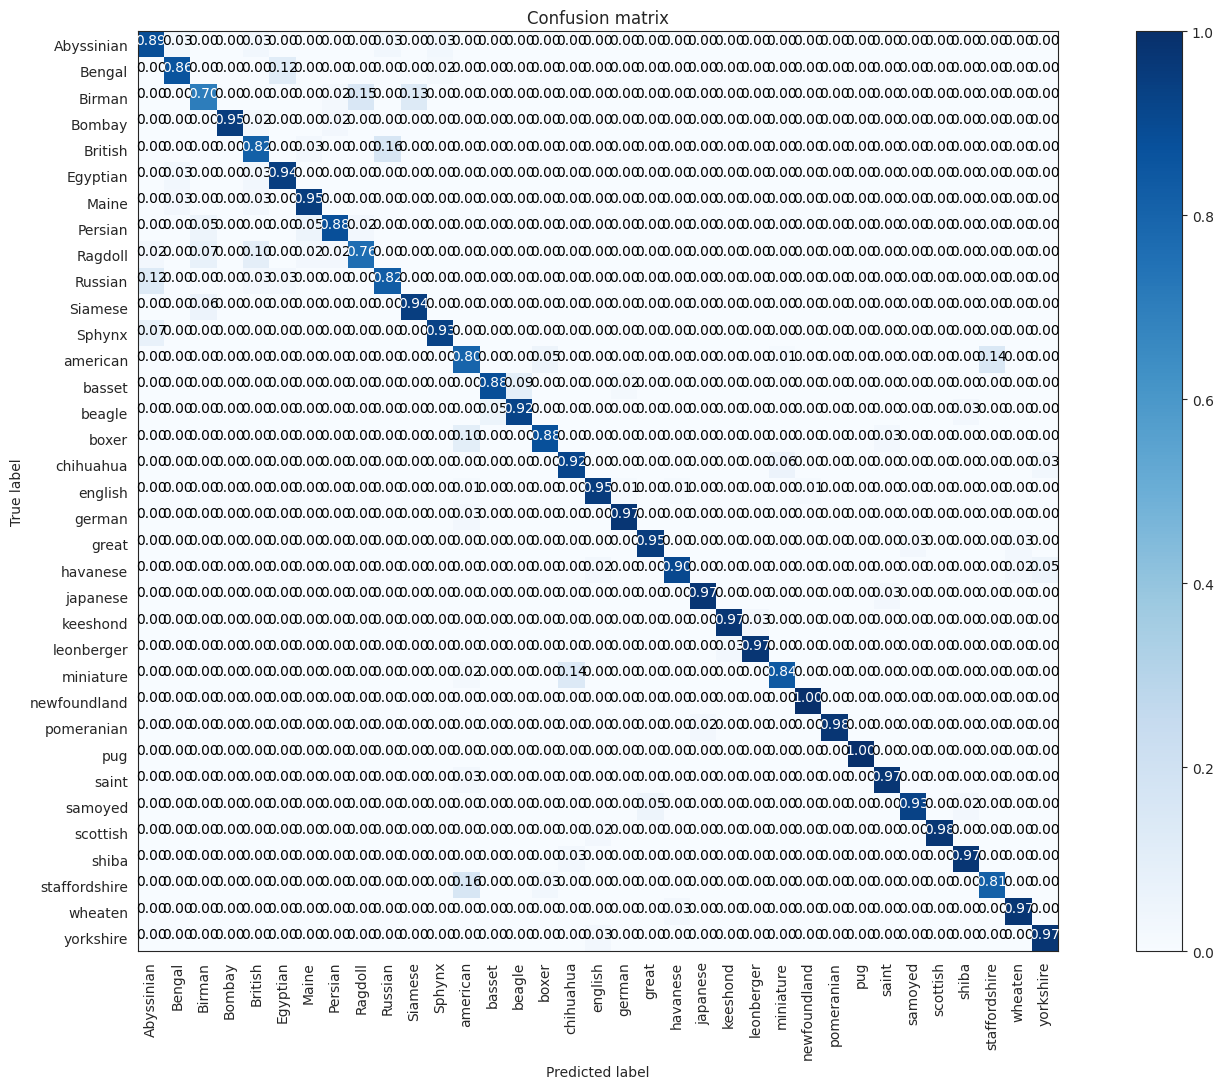

In [ ]:
print ('VGG16:')
y_test_all, predictions_all = show_confusion_matrix_fucn(fe_model_sсhed_2)
accurancy_for_each_class(y_test_all, predictions_all)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `model` is your convolutional model
fe_model_sсhed_2 = fe_model_sсhed_2.to(device)

In [ ]:
top3_correct = 0
top5_correct = 0

with torch.no_grad():
    for inputs, labels in test_batch_gen:
        predictions = fe_model_sсhed_2(inputs.to(device))
        _, top3_indices = torch.topk(predictions, k=3, dim=1)
        _, top5_indices = torch.topk(predictions, k=5, dim=1)

        for i in range(len(labels)):
            true_label = labels[i]

            if true_label.item() in top3_indices[i]:
                top3_correct += 1

            if true_label.item() in top5_indices[i]:
                top5_correct += 1

top3_accuracy = top3_correct * 100 / len(test_batch_gen.dataset)
top5_accuracy = top5_correct * 100 / len(test_batch_gen.dataset)

print('Top-3 Accuracy: {}%'.format(top3_accuracy))
print('Top-5 Accuracy: {}%'.format(top5_accuracy))

Top-3 Accuracy: 99.12043301759134%
Top-5 Accuracy: 99.6617050067659%


### VGG19

In [ ]:
from torchvision.models import vgg19

In [ ]:
model = vgg19(pretrained=True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 65.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Epoch 30 of 30 took 84.082s
  train loss (in-iteration): 	0.592231
  test loss (in-iteration): 	0.307994
  train accuracy: 			82.97 %
  test accuracy: 			91.99 %


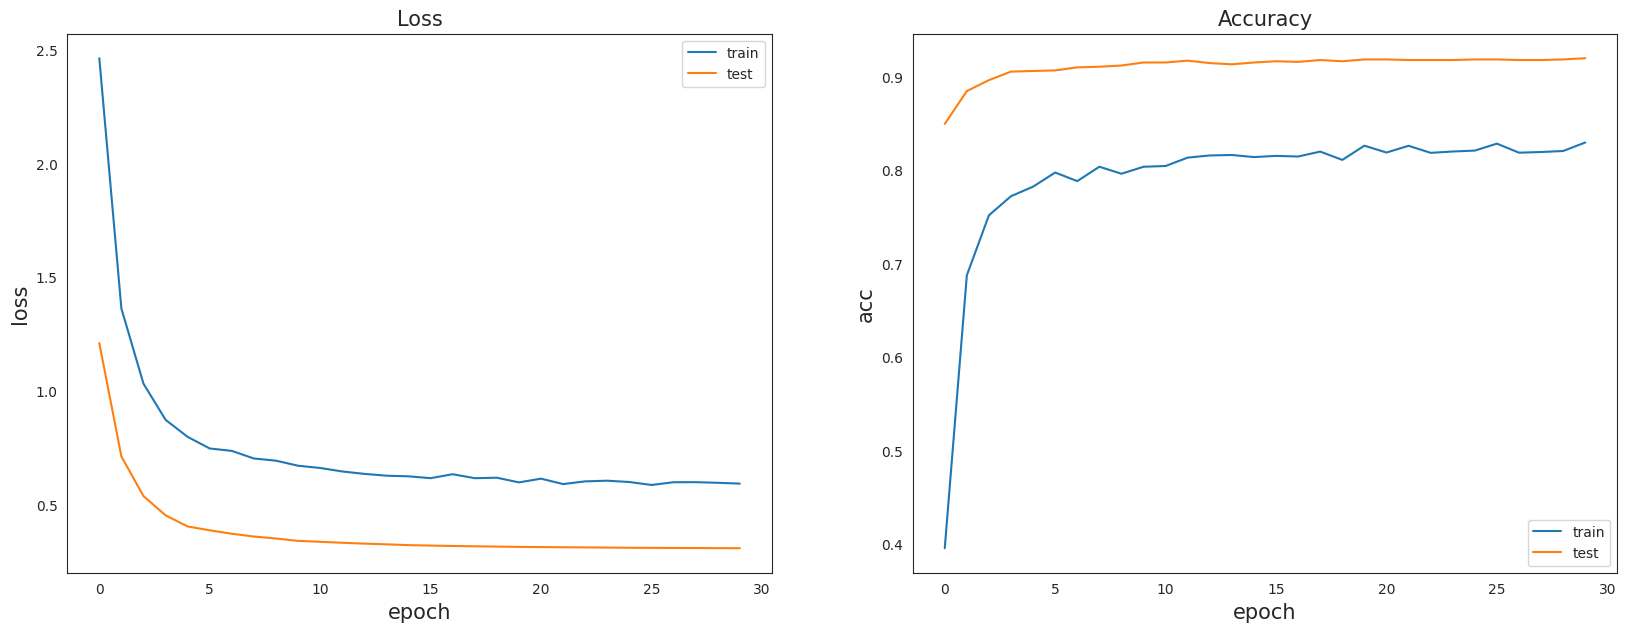

In [ ]:
# возьмём предобученную сеть
fe_model_sсhed_3 = vgg19(pretrained=True).to(device)

# заморозим все слои сети
for param in fe_model_sсhed_3.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model_sсhed_3.classifier
fe_model_sсhed_3.classifier[6] = nn.Linear(in_features=4096, out_features=35).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fe_model_sсhed_3.parameters(), lr=0.0001)

# добавим scheduler StepLR для пошагового снижения скорости обучения
scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

clf_model, history = train(
    fe_model_sсhed_3, criterion, optimizer,
    train_batch_gen, test_batch_gen,
    scheduler,
    num_epochs=30
)

In [ ]:
# Сохранение модели
torch.save(model.state_dict(), 'model_vgg19.pth')

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
#idxs = list(range(len(test_dataset)))
idxs = list(map(int, np.random.uniform(0, len(test_dataset), 20)))
imgs = [test_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims_vgg19 = predict(fe_model_sсhed_3, imgs)
y_pred_vgg = np.argmax(probs_ims_vgg19,-1)
y_pred_vgg = list(y_pred_vgg)
print('VGG19:        ', y_pred_vgg)
actual_labels = [test_dataset[id][1] for id in idxs]
print('Right answer: ', actual_labels)

VGG19:         [8, 34, 25, 25, 16, 10, 34, 5, 17, 9, 15, 19, 9, 22, 23, 17, 8, 33, 2, 0]
Right answer:  [8, 34, 25, 25, 16, 10, 34, 5, 17, 9, 12, 19, 9, 22, 23, 17, 8, 33, 8, 0]


In [ ]:
from sklearn.metrics import f1_score
sc_vgg=f1_score(actual_labels, y_pred_vgg, average='macro')
print ('VGG19: F1_score=', sc_vgg)

VGG19: F1_score= 0.9170687455618804


In [ ]:
n_classes = len(np.unique(test_dataset.classes))
print("we will classify :{}".format(n_classes))

we will classify :35


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

def show_confusion_matrix_fucn(model):

    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()


    with torch.no_grad():
        for inputs, labels in test_batch_gen:
            predictions = model(inputs.to(device))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)


            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(test_batch_gen.dataset.classes))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()


    cm = confusion_matrix(y_test_all, predictions_all)#, np.arange(n_classes))

    plot_confusion_matrix(cm, feature_names, normalize=True)

    return y_test_all, predictions_all

def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(test_batch_gen.dataset.classes))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
BATCH_SIZE = 64

dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'test': torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'test':len(test_dataset)}

VGG19:
Normalized confusion matrix
[41, 39, 47, 44, 34, 38, 38, 39, 39, 40, 40, 40, 84, 40, 39, 42, 38, 80, 40, 42, 42, 40, 41, 41, 42, 39, 42, 39, 38, 41, 41, 40, 31, 38, 39]
35
Accuracy of Abyssinian : 82 %
Accuracy of Bengal : 89 %
Accuracy of Birman : 72 %
Accuracy of Bombay : 90 %
Accuracy of British : 88 %
Accuracy of Egyptian : 94 %
Accuracy of Maine : 89 %
Accuracy of Persian : 92 %
Accuracy of Ragdoll : 74 %
Accuracy of Russian : 82 %
Accuracy of Siamese : 92 %
Accuracy of Sphynx : 97 %
Accuracy of american : 82 %
Accuracy of basset : 97 %
Accuracy of beagle : 94 %
Accuracy of boxer : 85 %
Accuracy of chihuahua : 92 %
Accuracy of english : 96 %
Accuracy of german : 97 %
Accuracy of great : 95 %
Accuracy of havanese : 90 %
Accuracy of japanese : 97 %
Accuracy of keeshond : 95 %
Accuracy of leonberger : 95 %
Accuracy of miniature : 88 %
Accuracy of newfoundland : 100 %
Accuracy of pomeranian : 92 %
Accuracy of   pug : 100 %
Accuracy of saint : 100 %
Accuracy of samoyed : 97 %
Ac

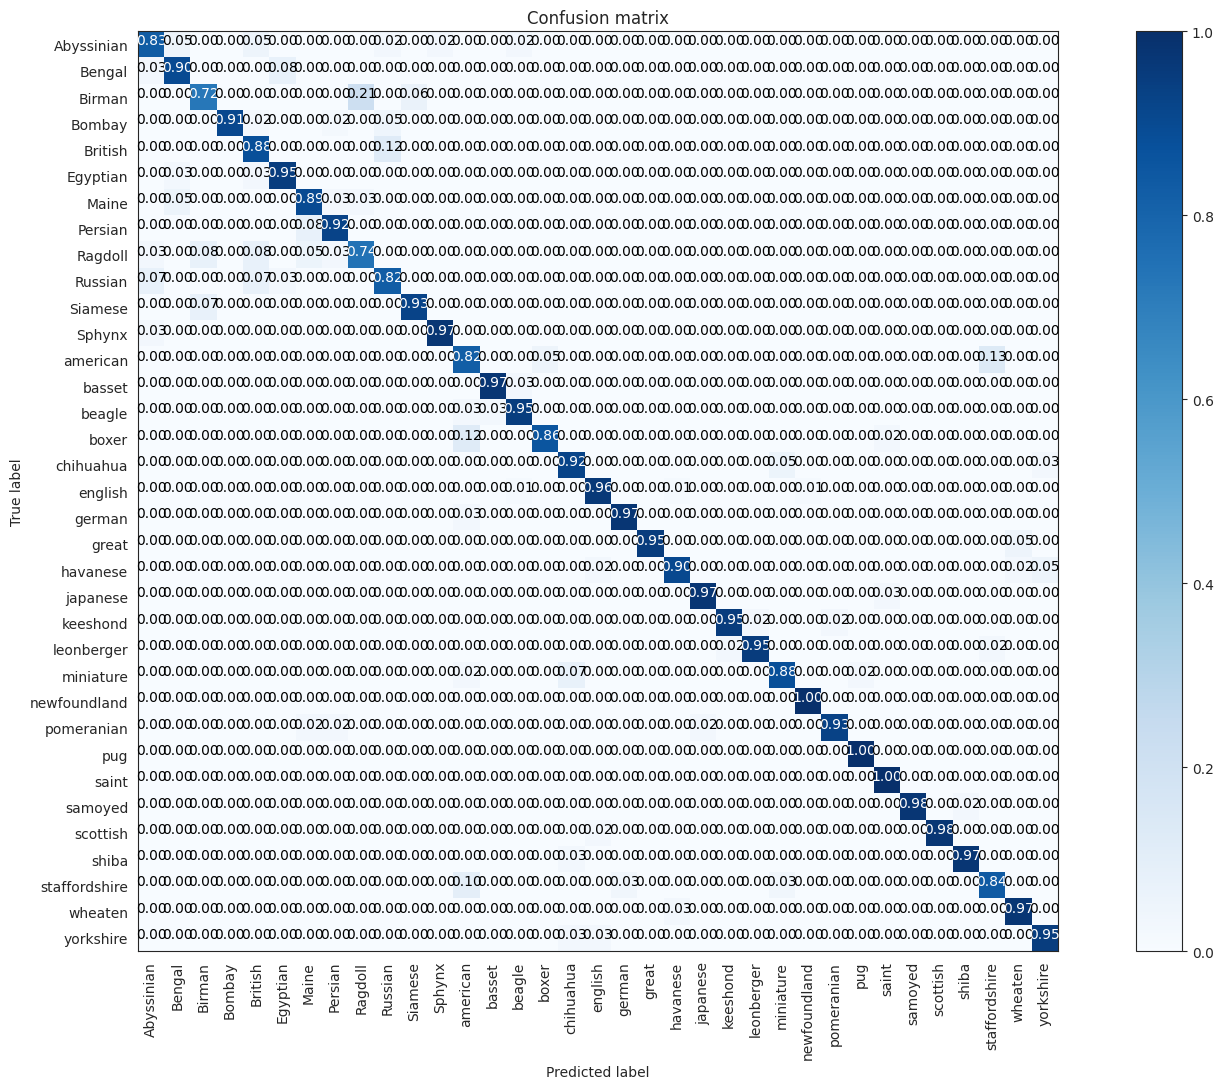

In [ ]:
print ('VGG19:')
y_test_all, predictions_all = show_confusion_matrix_fucn(fe_model_sсhed_3)
accurancy_for_each_class(y_test_all, predictions_all)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `model` is your convolutional model
fe_model_sсhed_3 = fe_model_sсhed_3.to(device)

In [ ]:
top3_correct = 0
top5_correct = 0

with torch.no_grad():
    for inputs, labels in test_batch_gen:
        predictions = fe_model_sсhed_3(inputs.to(device))
        _, top3_indices = torch.topk(predictions, k=3, dim=1)
        _, top5_indices = torch.topk(predictions, k=5, dim=1)

        for i in range(len(labels)):
            true_label = labels[i]

            if true_label.item() in top3_indices[i]:
                top3_correct += 1

            if true_label.item() in top5_indices[i]:
                top5_correct += 1

top3_accuracy = top3_correct * 100 / len(test_batch_gen.dataset)
top5_accuracy = top5_correct * 100 / len(test_batch_gen.dataset)

print('Top-3 Accuracy: {}%'.format(top3_accuracy))
print('Top-5 Accuracy: {}%'.format(top5_accuracy))

Top-3 Accuracy: 99.05277401894452%
Top-5 Accuracy: 99.6617050067659%


### VGG16 двоичная классификация (выбрана согласно наибольшего значения top_3 accuracy)

In [ ]:
!mkdir Dog_Cat
!mkdir Dog_Cat/Dog
!mkdir Dog_Cat/Cat

In [ ]:
import os
import shutil

source_dir = "images/"
dest_dir_upper = "Dog_Cat/Cat"
dest_dir_lower = "Dog_Cat/Dog"

files = os.listdir(source_dir)

for file in files:
    if file[0].isupper():
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir_upper, file))
    elif file[0].islower():
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir_lower, file))

In [ ]:
!rm -r images

In [6]:
# разделим картинки на train и test в отношении 80 на 20 для каждого класса
data_dir = "Dog_Cat/"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, test_files_path = train_test_split(
    data_image_paths,
    test_size=0.2,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в test: {len(test_files_path)}"
)


Изображений в train: 5912
Изображений в test: 1478


In [7]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

test_dataset = tv.datasets.ImageFolder(
    data_dir,
    transform=test_transform,
    is_valid_file=lambda x: x in test_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в test: ", len(test_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(test_dataset.classes))

Количество классов в train:  2
Количество классов в test:  2
Количество классов одинаково:  True


In [ ]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['test'], label='test')
    plt.ylabel('loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['test'], label='test')
    plt.ylabel('acc', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    test_batch_gen,
    scheduler,
    num_epochs
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()



            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = np.argmax(logits.detach().cpu().numpy(), axis=1)
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        scheduler.step()

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по тестовому датасету
        for X_batch, y_batch in test_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            test_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = np.argmax(logits.detach().cpu().numpy(), axis=1)
            test_acc += np.mean(y_batch.cpu().numpy() == y_pred)


        # подсчитываем лоссы и сохраням в "историю"
        test_loss /= len(test_batch_gen)
        test_acc /= len(test_batch_gen)
        history['loss']['test'].append(test_loss)
        history['acc']['test'].append(test_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  train loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  test loss (in-iteration): \t{:.6f}".format(test_loss))
        print("  train accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  test accuracy: \t\t\t{:.2f} %".format(test_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=True
)
# тестовый датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
test_batch_gen = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
from torchvision.models import vgg16

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Epoch 20 of 20 took 77.050s
  train loss (in-iteration): 	0.120374
  test loss (in-iteration): 	0.023310
  train accuracy: 			95.37 %
  test accuracy: 			99.41 %


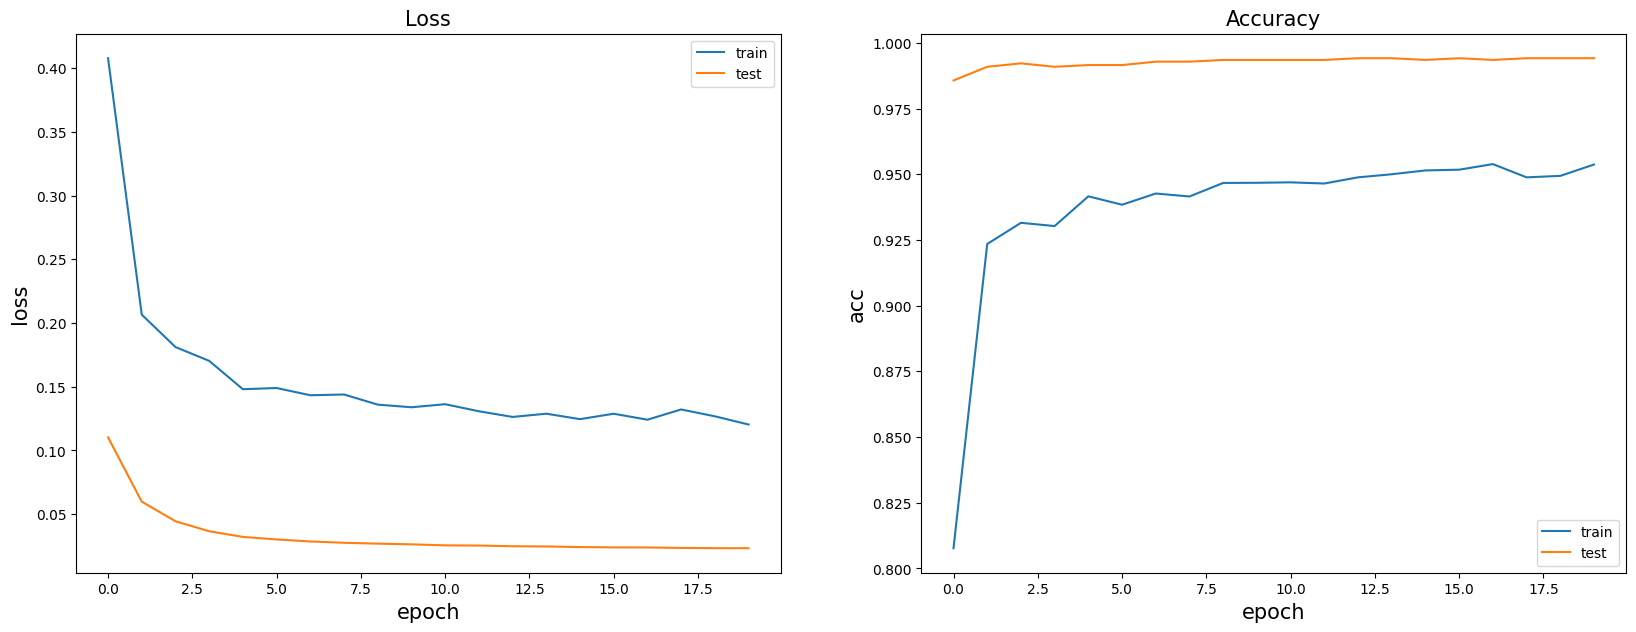

In [ ]:
# возьмём предобученную сеть
fe_model_sсhed_2_2 = vgg16(pretrained=True).to(device)

# заморозим все слои сети
for param in fe_model_sсhed_2_2.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model_sсhed_2_2.classifier
fe_model_sсhed_2_2.classifier[6] = nn.Linear(in_features=4096, out_features=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fe_model_sсhed_2_2.parameters(), lr=0.0001)

# добавим scheduler StepLR для пошагового снижения скорости обучения
scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

clf_model, history = train(
    fe_model_sсhed_2_2, criterion, optimizer,
    train_batch_gen, test_batch_gen,
    scheduler,
    num_epochs=20
)

In [ ]:
torch.save(fe_model_sсhed_2_2.state_dict(), 'model_vgg16_2.pth')

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
#idxs = list(range(len(test_dataset)))
idxs = list(map(int, np.random.uniform(0, len(test_dataset), 20)))
imgs = [test_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims_vgg16 = predict(fe_model_sсhed_2_2, imgs)
y_pred_vgg = np.argmax(probs_ims_vgg16,-1)
y_pred_vgg = list(y_pred_vgg)
print('VGG16:        ', y_pred_vgg)
actual_labels = [test_dataset[id][1] for id in idxs]
print('Right answer: ', actual_labels)

VGG16:         [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]
Right answer:  [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0]


In [ ]:
from sklearn.metrics import f1_score
sc_vgg=f1_score(actual_labels, y_pred_vgg, average='macro')
print ('VGG19: F1_score=', sc_vgg)

VGG19: F1_score= 0.9930390825529642


In [ ]:
n_classes = len(np.unique(test_dataset.classes))
print("we will classify :{}".format(n_classes))

we will classify :2


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

def show_confusion_matrix_fucn(model):

    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()


    with torch.no_grad():
        for inputs, labels in test_batch_gen:
            predictions = model(inputs.to(device))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)


            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = sorted(set(test_batch_gen.dataset.classes))

    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()


    cm = confusion_matrix(y_test_all, predictions_all)#, np.arange(n_classes))

    plot_confusion_matrix(cm, feature_names, normalize=True)

    return y_test_all, predictions_all

def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(n_classes)]
    class_total = [0 for i in range(n_classes)]
    feature_names = sorted(set(test_batch_gen.dataset.classes))

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(n_classes):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

In [ ]:
BATCH_SIZE = 64

dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'test': torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'test':len(test_dataset)}

VGG16:
Normalized confusion matrix
[475, 1003]
2
Accuracy of   Cat : 99 %
Accuracy of   Dog : 99 %


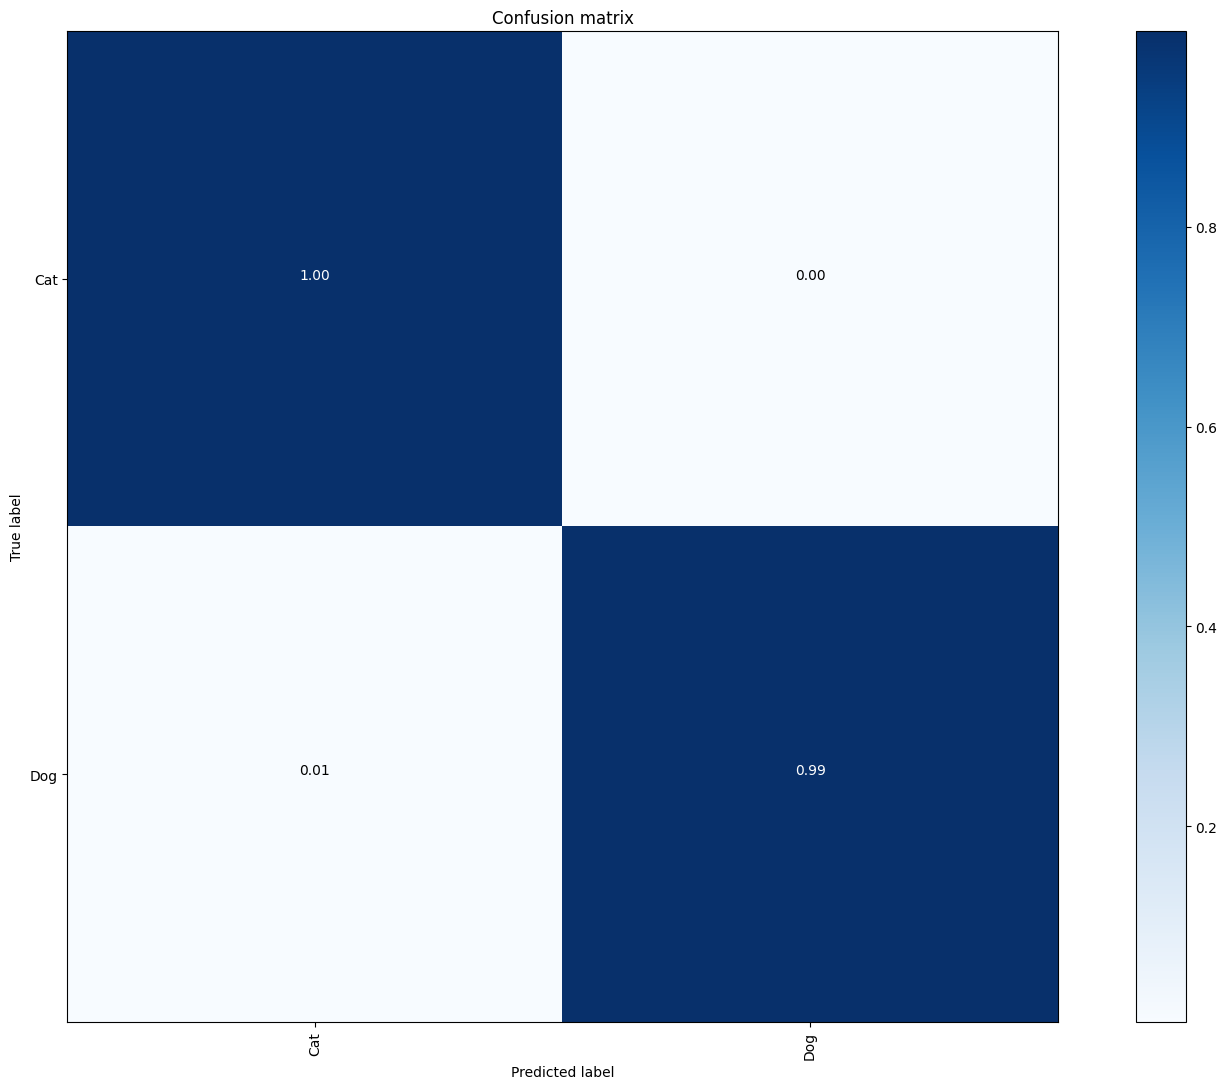

In [ ]:
print ('VGG16:')
y_test_all, predictions_all = show_confusion_matrix_fucn(fe_model_sсhed_2_2)
accurancy_for_each_class(y_test_all, predictions_all)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `model` is your convolutional model
fe_model_sched_2_2 = fe_model_sсhed_2_2.to(device)

In [ ]:
top3_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_batch_gen:
        predictions = fe_model_sсhed_2_2(inputs.to(device))
        predictions = predictions.view(-1)  # Преобразовать в одномерный тензор
        _, top3_indices = torch.topk(predictions, k=3, dim=0, largest=True, sorted=True)
        _, top5_indices = torch.topk(predictions, k=5, dim=0, largest=True, sorted=True)

        total += labels.size(0)

        for i in range(len(labels)):
            if i >= len(top3_indices):
                top3_correct += 1
            elif true_label.item() in top3_indices[i]:
                top3_correct += 1

            if i >= len(top5_indices):
                top5_correct += 1
            elif true_label.item() in top5_indices[i]:
                top5_correct += 1

top3_accuracy = top3_correct * 100 / total
top5_accuracy = top5_correct * 100 / total

print('Top-3 Accuracy: {}%'.format(top3_accuracy))
print('Top-5 Accuracy: {}%'.format(top5_accuracy))

Top-3 Accuracy: 95.12855209742895%
Top-5 Accuracy: 91.8809201623816%


### GradCam

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

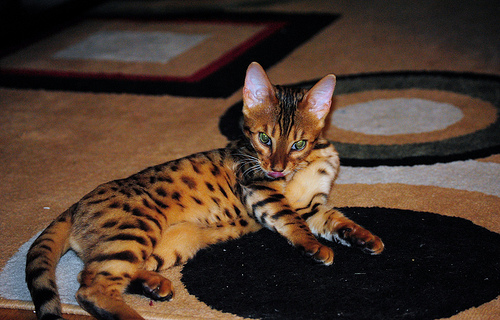

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = 'images/Bengal/Bengal_106.jpg'


display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n02124075', 'Egyptian_cat', 9.207535)]


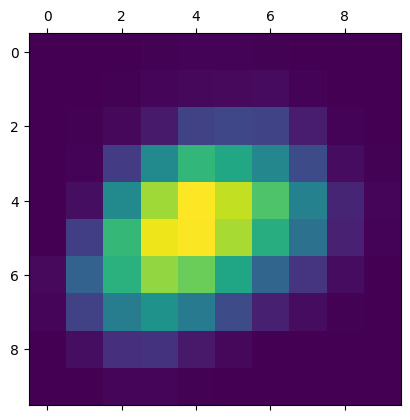

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

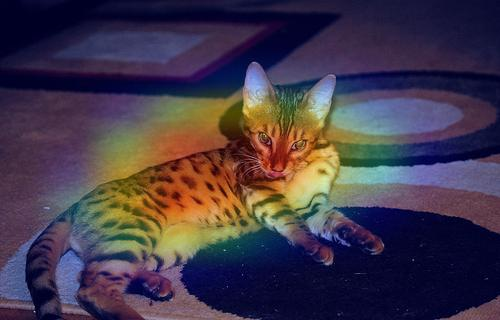

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
image_paths = ['images/Bengal/Bengal_106.jpg', 'images/Siamese/Siamese_14.jpg', 'images/Maine/Maine_Coon_10.jpg', 'images/Persian/Persian_34.jpg', 'images/Ragdoll/Ragdoll_103.jpg']
class_names = ['Bengal', 'Siamese', 'Maine', 'Persian', 'Ragdoll']

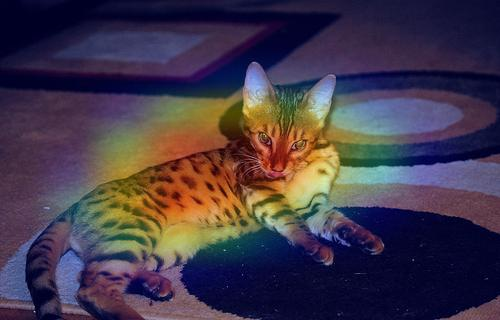

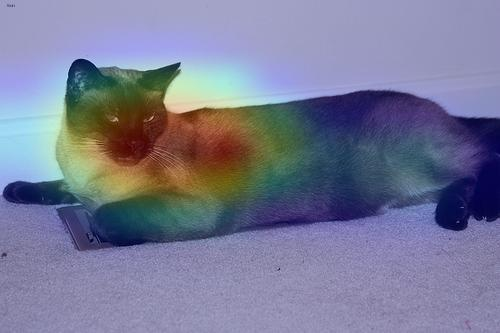

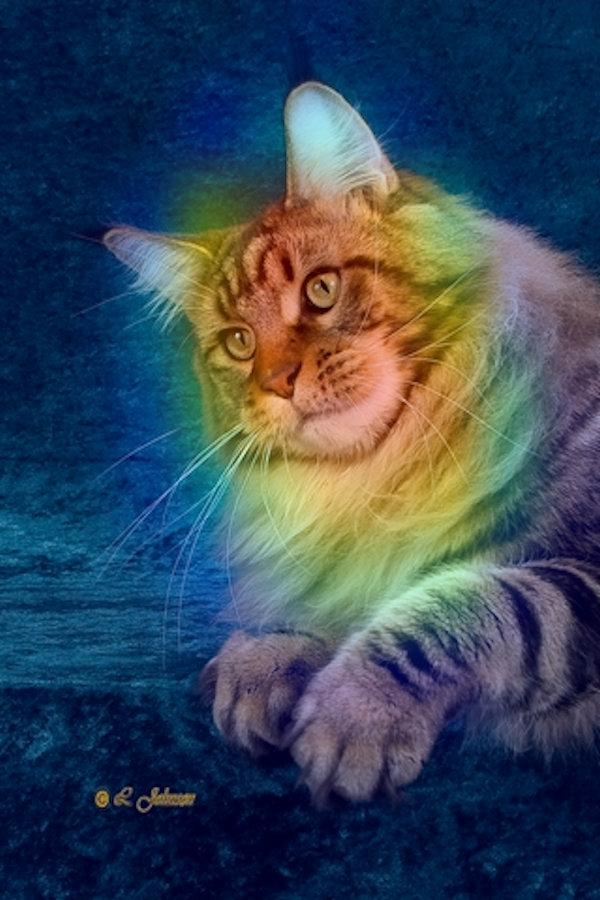

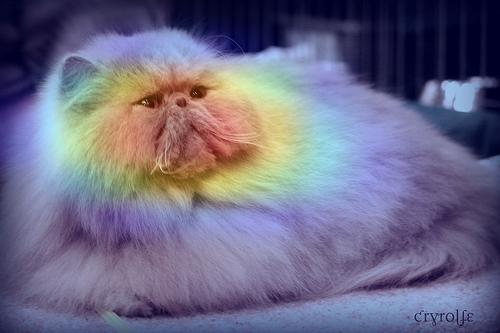

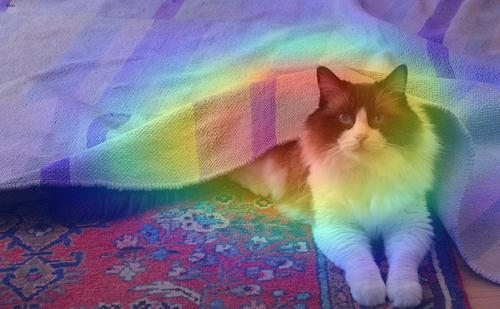

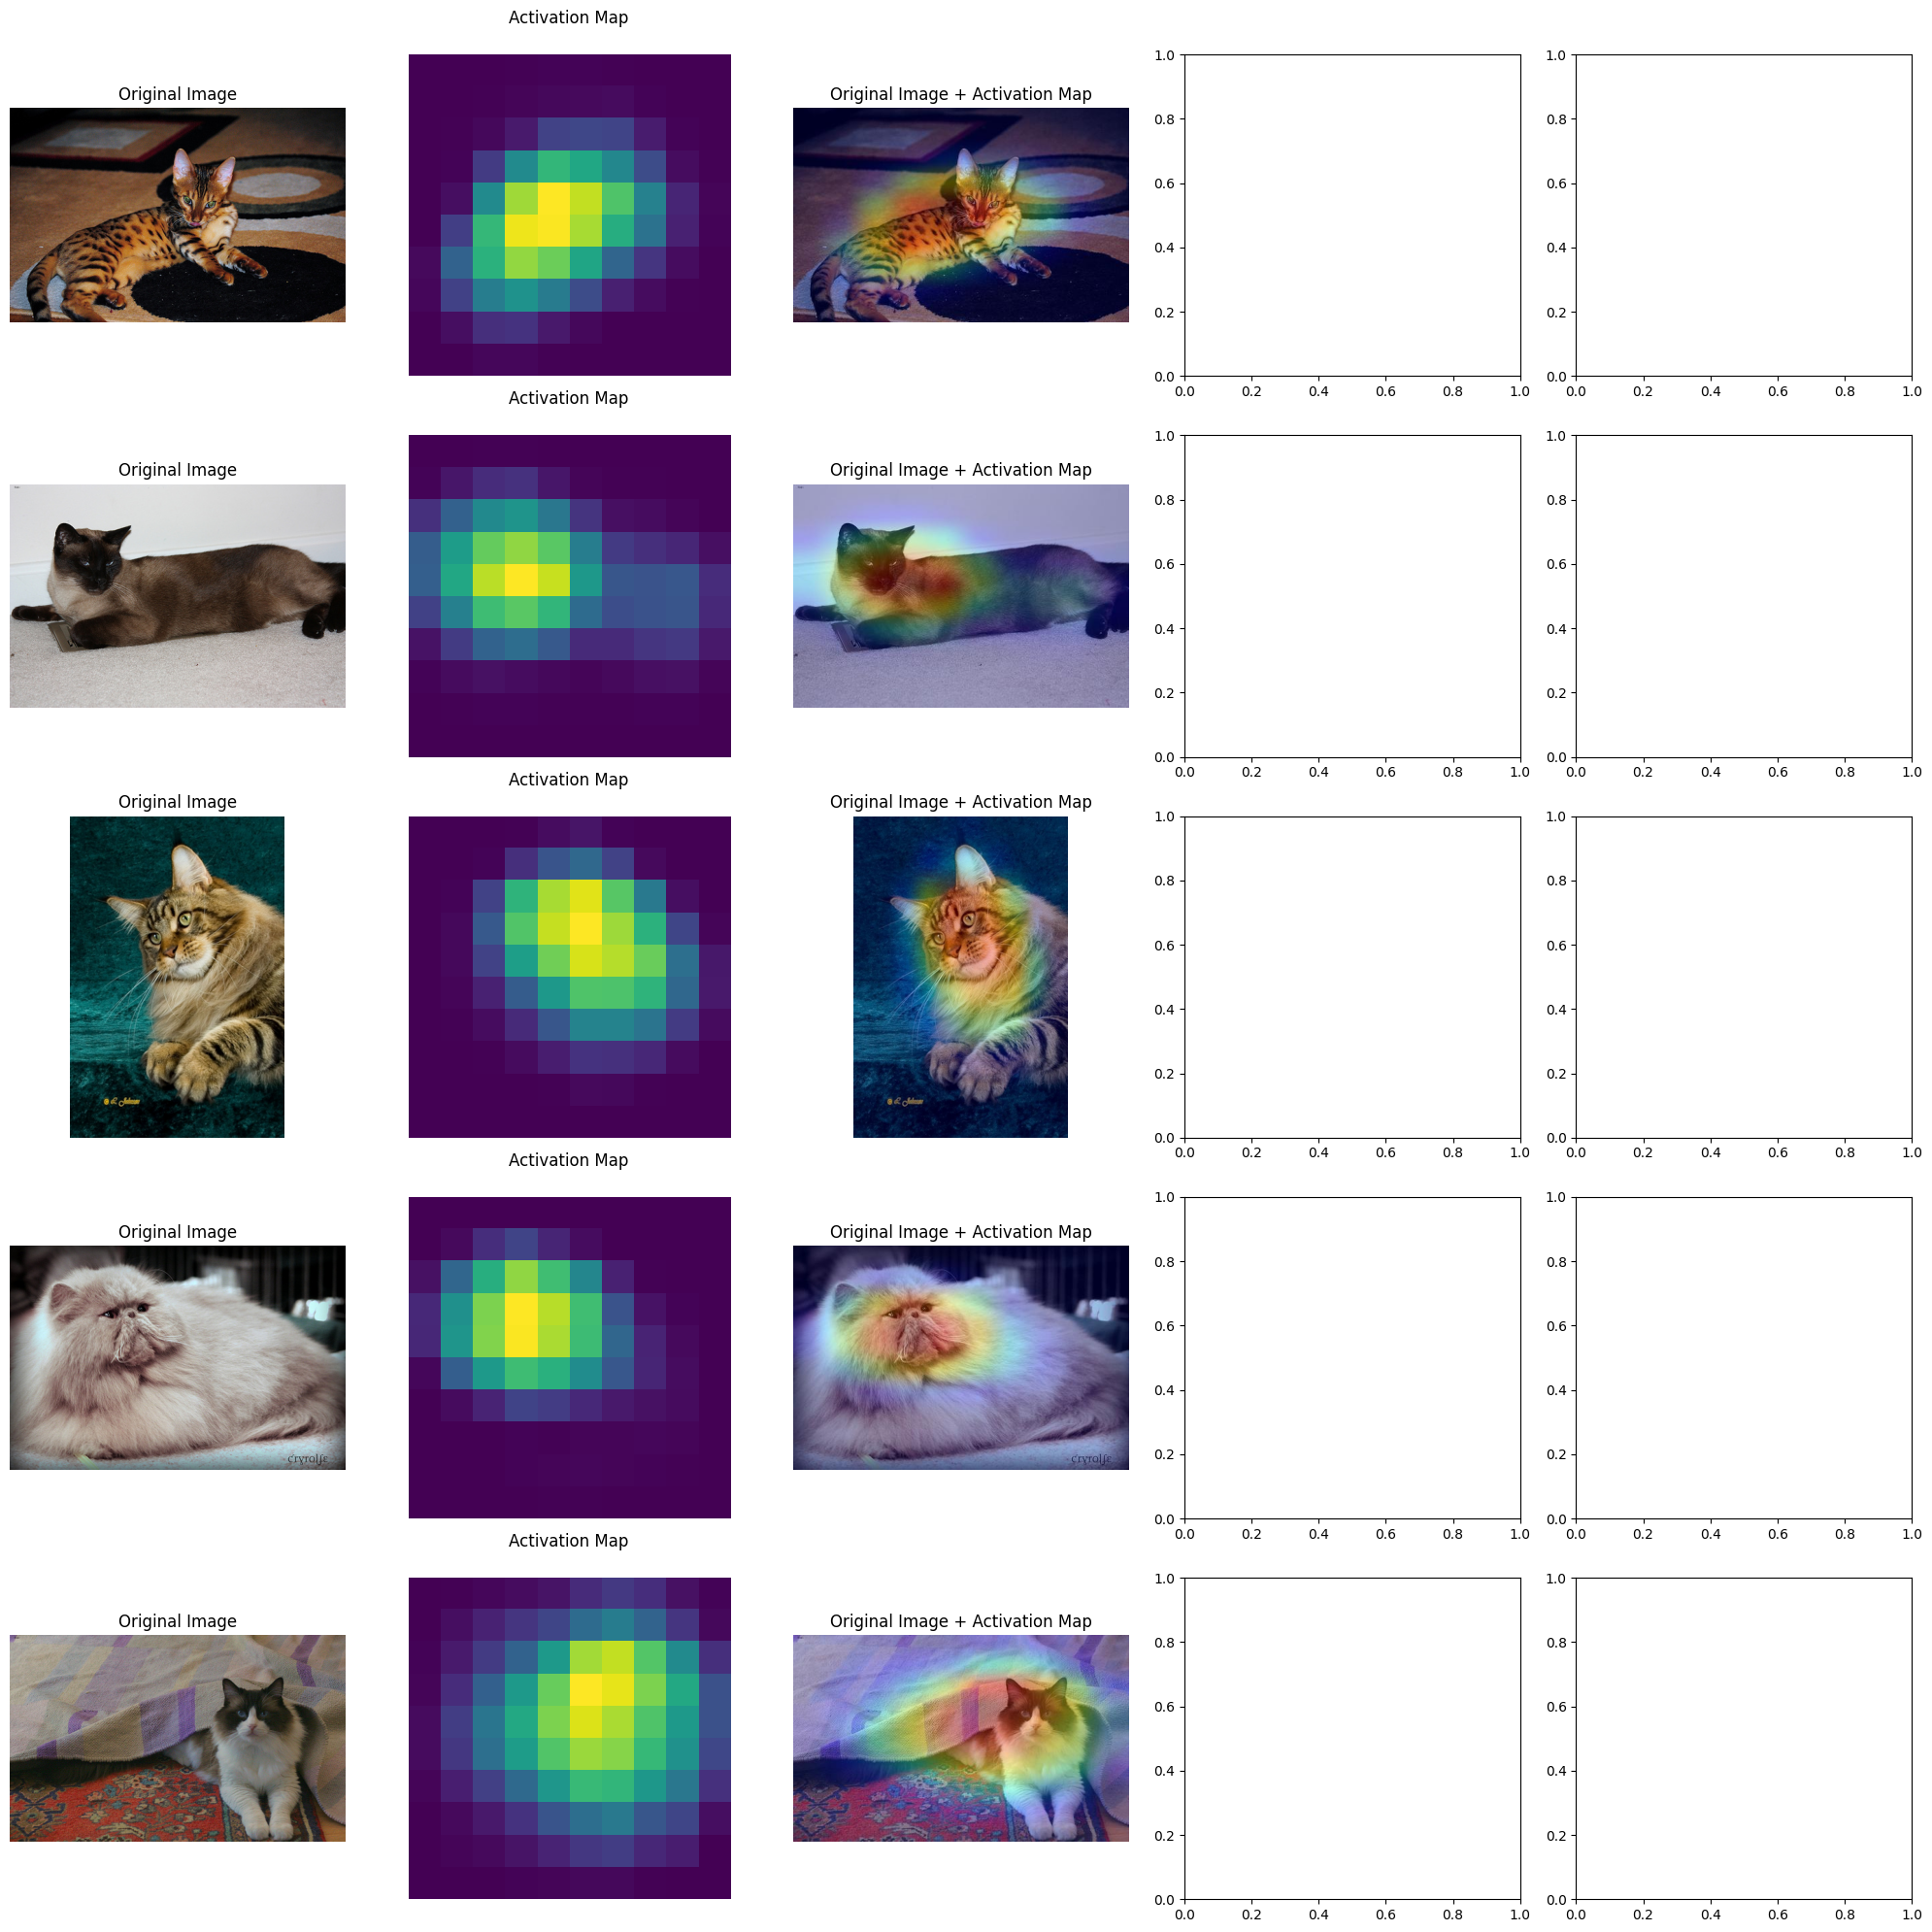

In [ ]:
# Создаем сетку 5x5 для отображения изображений и карт активации
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for i in range(len(image_paths)):
    # Загружаем изображение
    img_path = image_paths[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Создаем модель и генерируем карту активации
    model = model_builder(weights="imagenet")
    model.layers[-1].activation = None
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Сохраняем и выводим карту активации
    cam_path = "cam.jpg"
    save_and_display_gradcam(img_path, heatmap, cam_path)

    # Отображаем изображение в первом столбце
    image = plt.imread(img_path)
    axs[i, 0].imshow(image)
    axs[i, 0].axis("off")

     # Отображаем изображение карты активации во втором столбце
    image = plt.imread(img_path)
    axs[i, 1].matshow(heatmap)
    axs[i, 1].axis("off")

    # Отображаем изображение с картой активации в третьем столбце
    heatmap_image = plt.imread(cam_path)
    axs[i, 2].imshow(heatmap_image)
    axs[i, 2].axis("off")

    # Настройки заголовков изображений
    axs[i, 0].set_title("Original Image")
    axs[i, 1].set_title("Activation Map")
    axs[i, 2].set_title("Original Image + Activation Map")

    # Настройки заголовков классов
    axs[i, 0].set_ylabel(class_names[i])

plt.tight_layout()
plt.show()